In [7]:
import tensorflow as tf
from tensorflow.keras import models,layers



In [9]:
import matplotlib.pyplot as plt

In [27]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [14]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [15]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [16]:
len(dataset)

68

In [17]:
68*32

2176

In [19]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 2 0 1 2]


In [20]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[105. 103. 117.]
  [156. 154. 168.]
  [157. 155. 169.]
  ...
  [196. 198. 210.]
  [195. 197. 209.]
  [190. 192. 204.]]

 [[151. 149. 163.]
  [ 98.  96. 110.]
  [119. 117. 131.]
  ...
  [188. 190. 202.]
  [192. 194. 206.]
  [192. 194. 206.]]

 [[ 84.  82.  96.]
  [136. 134. 148.]
  [114. 112. 126.]
  ...
  [184. 186. 198.]
  [195. 197. 209.]
  [199. 201. 213.]]

 ...

 [[146. 143. 162.]
  [102.  99. 118.]
  [149. 146. 165.]
  ...
  [195. 199. 211.]
  [164. 168. 179.]
  [184. 188. 199.]]

 [[ 91.  88. 107.]
  [143. 140. 159.]
  [111. 108. 127.]
  ...
  [161. 165. 176.]
  [138. 142. 153.]
  [159. 163. 174.]]

 [[134. 131. 150.]
  [102.  99. 118.]
  [127. 124. 143.]
  ...
  [177. 181. 192.]
  [171. 175. 186.]
  [174. 178. 189.]]]


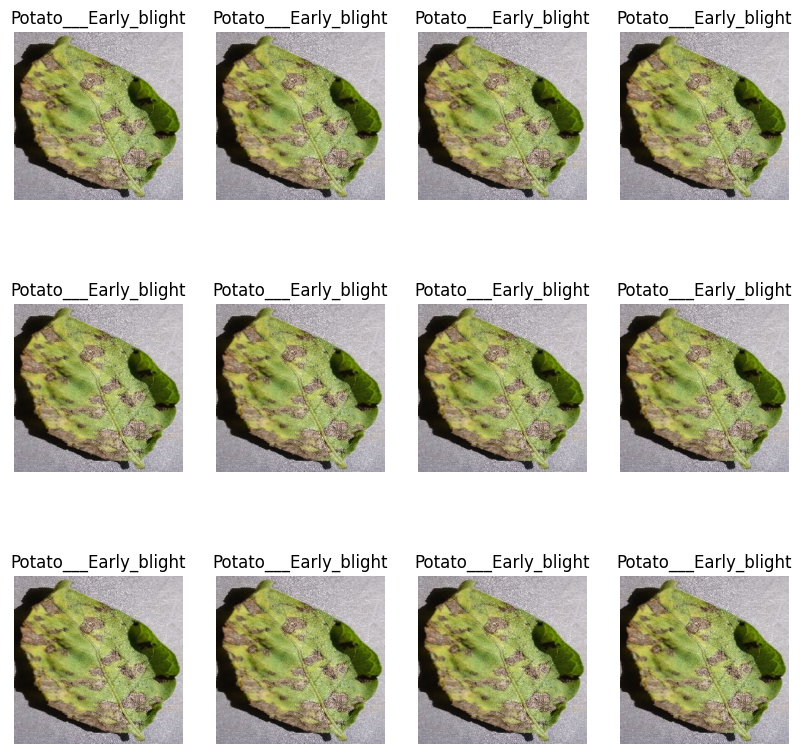

In [24]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")
    

In [26]:
# 80% training 10% validation 10% test

In [29]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [30]:
train_ds=dataset.take(54)
len(train_ds)

54

In [32]:
test_ds=dataset.skip(54)
len(test_ds)


14

In [35]:
val_size=0.1
len(dataset)*val_size


6.800000000000001

In [36]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [37]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [40]:
# Function to split data
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds
    

In [41]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [42]:
len(train_ds)

54

In [43]:
len(val_ds)


6

In [44]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset


In [46]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [47]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation

In [48]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Applying Data Augmentation to Train Dataset

In [49]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Architecture

In [50]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model

In [52]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [53]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 89s 1s/step - loss: 0.9025 - accuracy: 0.5098 - val_loss: 0.8374 - val_accuracy: 0.5729
Epoch 2/50
54/54 [==============================] - 78s 1s/step - loss: 0.6147 - accuracy: 0.6892 - val_loss: 0.5339 - val_accuracy: 0.7708
Epoch 3/50
54/54 [==============================] - 88s 2s/step - loss: 0.4854 - accuracy: 0.7807 - val_loss: 0.4105 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 76s 1s/step - loss: 0.3514 - accuracy: 0.8675 - val_loss: 0.2878 - val_accuracy: 0.8802
Epoch 5/50
54/54 [==============================] - 72s 1s/step - loss: 0.1654 - accuracy: 0.9387 - val_loss: 0.1515 - val_accuracy: 0.9531
Epoch 6/50
54/54 [==============================] - 69s 1s/step - loss: 0.1323 - accuracy: 0.9537 - val_loss: 0.2506 - val_accuracy: 0.9115
Epoch 7/50
54/54 [==============================] - 70s 1s/step - loss: 0.1622 - accuracy: 0.9381 - val_loss: 0.2601 - val_accuracy: 0.9062
Epoch 8/50
54/54 [==

In [54]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 301ms/step - loss: 0.0175 - accuracy: 0.9922


In [55]:
scores

[0.017481017857789993, 0.9921875]

Plotting the Accuracy and Loss Curves

In [56]:
history

In [57]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [58]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
type(history.history['loss'])

list

In [60]:
len(history.history['loss'])

50

In [61]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9025188684463501,
 0.6146832704544067,
 0.48537927865982056,
 0.3513542115688324,
 0.16541340947151184]

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [67]:
acc

[0.5098379850387573,
 0.6892361044883728,
 0.7806712985038757,
 0.8674768805503845,
 0.9386574029922485,
 0.9537037014961243,
 0.9380787014961243,
 0.9675925970077515,
 0.96875,
 0.9461805820465088,
 0.9693287014961243,
 0.9710648059844971,
 0.9751157164573669,
 0.9704861044883728,
 0.9809027910232544,
 0.9722222089767456,
 0.9664351940155029,
 0.9826388955116272,
 0.9832175970077515,
 0.9907407164573669,
 0.9473379850387573,
 0.9878472089767456,
 0.9895833134651184,
 0.9913194179534912,
 0.9866898059844971,
 0.9890046119689941,
 0.984375,
 0.984375,
 0.9930555820465088,
 0.9907407164573669,
 0.9936342835426331,
 0.9924768805503845,
 0.9901620149612427,
 0.9890046119689941,
 0.9635416865348816,
 0.9866898059844971,
 0.9780092835426331,
 0.9947916865348816,
 0.9878472089767456,
 0.9965277910232544,
 0.9994212985038757,
 0.9826388955116272,
 0.9814814925193787,
 0.9878472089767456,
 0.9722222089767456,
 0.9971064925193787,
 0.9971064925193787,
 0.9965277910232544,
 0.9971064925193787,
 0

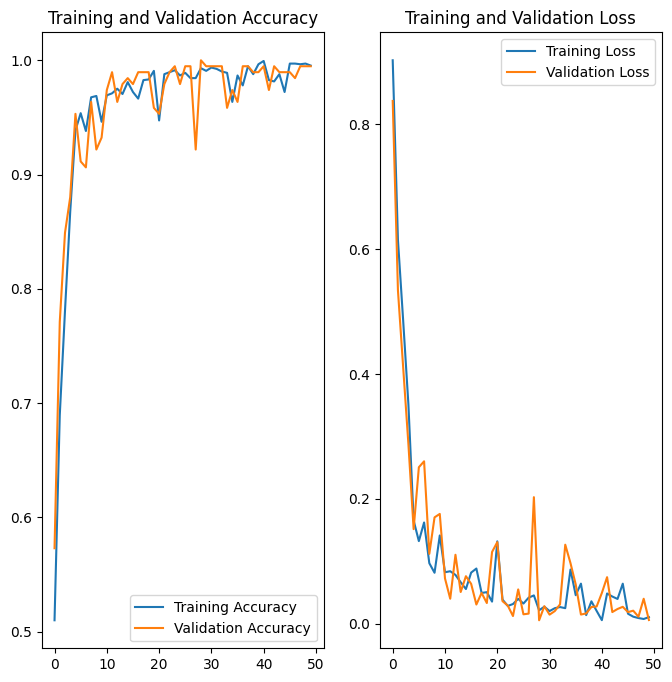

In [63]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 808ms/step
predicted label: Potato___Early_blight


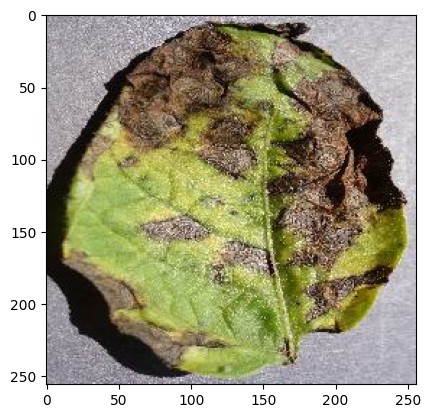

In [64]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 52ms/step


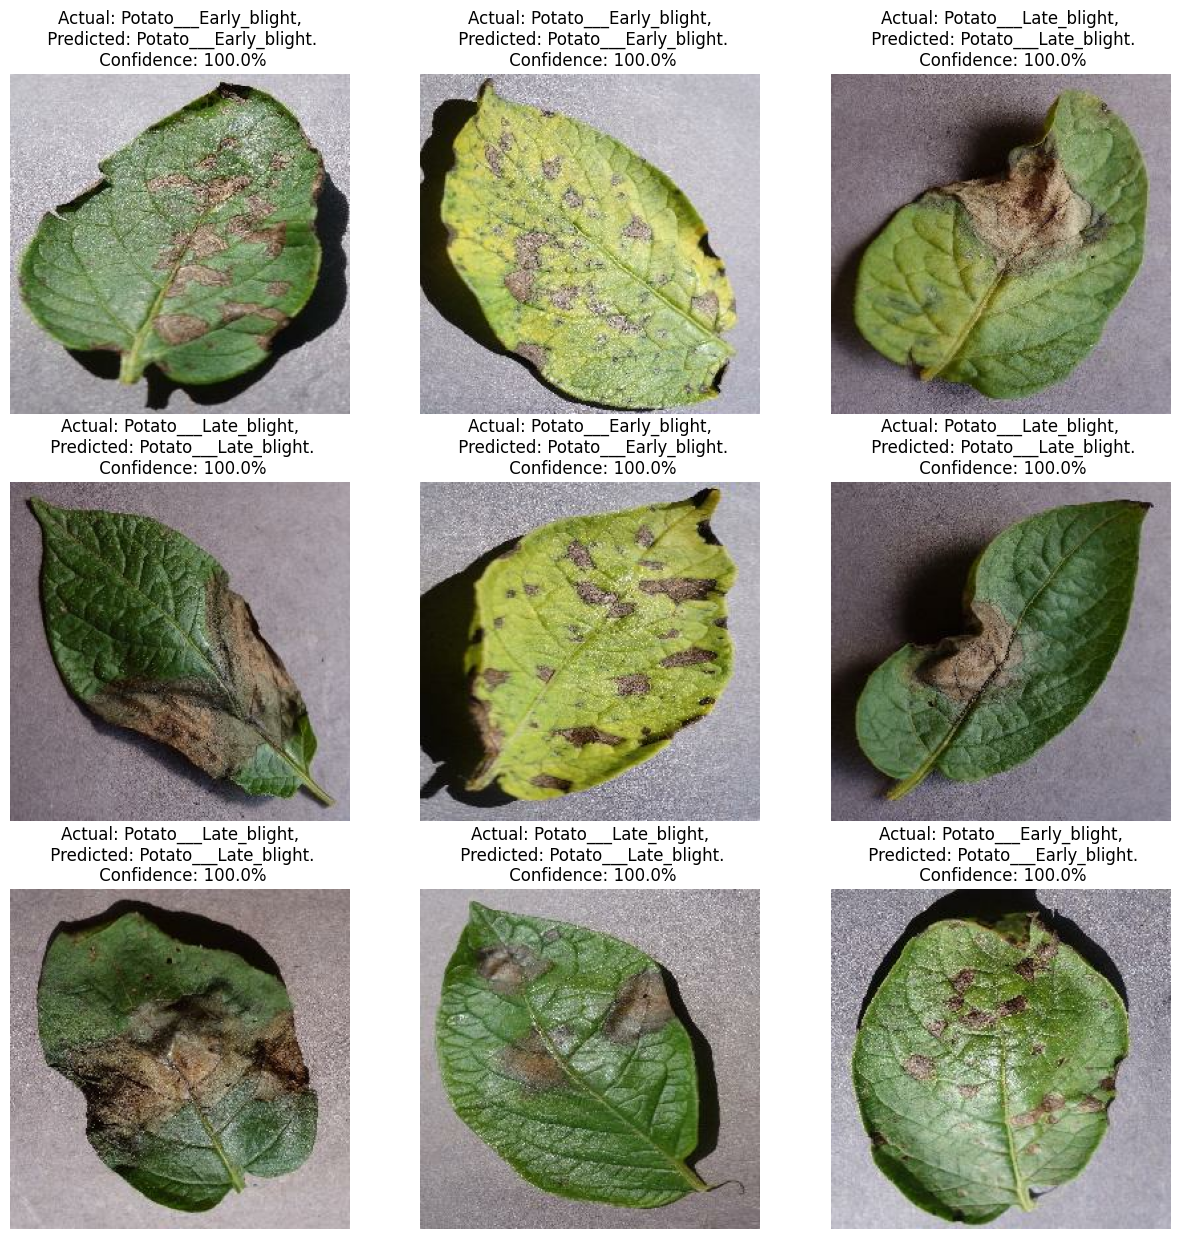

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Saving the Model

In [68]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [69]:
model.save("../potatoes.h5")

C:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
